In [131]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [132]:
%%writefile home/lab6_code_1.stan

data {
    int<lower=1> N;
}

generated quantities {
    real theta = 0.1;
    array [N] real y;
    for (i in 1:N) {
        if (bernoulli_rng(theta)) {
            y[i] = normal_rng(10, 10);
        }
        else {
            y[i] = normal_rng(1, 1);
        }
    }
}

Overwriting home/lab6_code_1.stan


In [133]:
%%writefile home/lab6_code_2.stan

data {
    int<lower=1> N;
}

generated quantities {
    matrix[N,3] X;
    {vector [N] zeros = rep_vector(0, N);

    for (j in 1:3) {
        X[:,j] = to_vector(normal_rng(zeros, 1));
    }
    }

    vector [3] beta;
    beta = [2, 1, 0.5]';

    array[N] real y;
    y = normal_rng(X*beta, 1);
}

Overwriting home/lab6_code_2.stan


In [134]:
model_1=CmdStanModel(stan_file='home/lab6_code_1.stan')

INFO:cmdstanpy:compiling stan file /home/lab6_code_1.stan to exe file /home/lab6_code_1
INFO:cmdstanpy:compiled model executable: /home/lab6_code_1


In [135]:
model_2=CmdStanModel(stan_file='home/lab6_code_2.stan')

INFO:cmdstanpy:compiling stan file /home/lab6_code_2.stan to exe file /home/lab6_code_2
INFO:cmdstanpy:compiled model executable: /home/lab6_code_2


In [136]:
F = len('Andrzej')
L = len('Janik')
N = (L+F)*100
N

1200

In [137]:
data1 = model_1.sample(data={'N': N}, iter_sampling=1, iter_warmup=1, chains=1, seed=29042020 )

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [138]:
df1 = data1.draws_pd()
df1.head()

,lp__,accept_stat__,theta,y[1],y[2],y[3],y[4],y[5],y[6],y[7],...,y[1191],y[1192],y[1193],y[1194],y[1195],y[1196],y[1197],y[1198],y[1199],y[1200]
0,0.0,0.0,0.1,0.575498,0.936339,0.166115,2.55158,0.637755,1.74349,1.97084,...,0.82073,2.84911,-0.727297,0.595016,2.08221,-0.00288,-0.352847,1.92261,-0.209063,0.950039


In [139]:
data2 = model_2.sample(data={'N': N}, iter_sampling=1, iter_warmup=1, chains=1, seed=29042020 )

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [140]:
df2 = data2.draws_pd()
df2.head()

,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[1191],y[1192],y[1193],y[1194],y[1195],y[1196],y[1197],y[1198],y[1199],y[1200]
0,0.0,0.0,2.70817,0.777181,-1.27227,0.127591,-1.38942,0.246162,1.19873,2.26533,...,-1.73839,5.82632,0.467584,5.68971,1.48844,-1.80466,-2.98097,2.59505,-3.23928,1.37315


In [141]:
%%writefile home/lab6_code_3.stan
data {
    int N;
    array [N] real y;
}

parameters {
    real<lower=0> sigma;
    real mu;
}

model {
    target += -2*log(sigma);
    target += normal_lpdf(y | mu, sigma);
}

generated quantities {
    vector [N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
        y_hat[j] = normal_rng(mu, sigma);
    }
}

Overwriting home/lab6_code_3.stan


In [142]:
%%writefile home/lab6_code_4.stan
data {
    int N;
    array [N] real y;
}

parameters {
    real<lower=0> sigma;
    real mu;
    real<lower=0> nu;
}

model {
    target += -2*log(sigma);
    target += gamma_lpdf(nu | 2, 0.1);
    target += student_t_lpdf(y | nu, mu,  sigma);
}

generated quantities {
    vector [N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = student_t_lpdf(y[j] | nu, mu, sigma);
        y_hat[j] = student_t_rng(nu, mu, sigma);
    }
}

Overwriting home/lab6_code_4.stan


In [143]:
model_3=CmdStanModel(stan_file='home/lab6_code_3.stan')

INFO:cmdstanpy:compiling stan file /home/lab6_code_3.stan to exe file /home/lab6_code_3
INFO:cmdstanpy:compiled model executable: /home/lab6_code_3


In [144]:
model_4=CmdStanModel(stan_file='home/lab6_code_4.stan')

INFO:cmdstanpy:compiling stan file /home/lab6_code_4.stan to exe file /home/lab6_code_4
INFO:cmdstanpy:compiled model executable: /home/lab6_code_4


In [145]:
dt = df1.loc[0, 'y[1]':]  #.values.reshape((N, ))
#dt.head()
data_fit = {'N': N, 'y': dt}
dt.shape

(1200,)

In [146]:
fit_model_3 = model_3.sample(data=data_fit, iter_sampling=100, iter_warmup=1, chains=1, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


In [147]:
df3 = fit_model_3.draws_pd()
df3.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,log_lik[1],...,y_hat[1191],y_hat[1192],y_hat[1193],y_hat[1194],y_hat[1195],y_hat[1196],y_hat[1197],y_hat[1198],y_hat[1199],y_hat[1200]
0,-4373.45,0.0,14.3855,0.0,1.0,1.0,4373.48,2.17394,0.954686,-1.71069,...,0.150260,1.734350,2.42123,-0.348656,1.126090,-0.300249,-0.727573,-0.757951,1.593150,2.651520
1,-4373.45,0.0,14.3855,0.0,1.0,1.0,4375.99,2.17394,0.954686,-1.71069,...,4.028660,0.226361,4.45301,1.904000,3.946810,0.911031,-0.814353,0.360253,0.214708,1.732650
2,-4373.45,0.0,14.3855,0.0,1.0,1.0,4373.89,2.17394,0.954686,-1.71069,...,-1.498660,3.032830,2.29637,0.274810,0.927857,0.582819,0.228932,0.343525,-3.026890,-0.216942
3,-4373.45,0.0,14.3855,0.0,1.0,1.0,4373.68,2.17394,0.954686,-1.71069,...,-0.891905,0.259741,1.66791,-1.529680,0.809294,3.288220,-3.023460,3.085600,2.758240,0.554709
4,-4373.45,0.0,14.3855,0.0,1.0,1.0,4374.41,2.17394,0.954686,-1.71069,...,-0.532057,2.382950,5.32216,2.411900,2.962920,2.130670,-1.238460,2.730480,0.108342,-1.138650


In [148]:
fit_model_4 = model_4.sample(data=data_fit, iter_sampling=100, iter_warmup=1, chains=1, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


In [149]:
df4 = fit_model_4.draws_pd()
df4.head()
#df4.shape

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,nu,...,y_hat[1191],y_hat[1192],y_hat[1193],y_hat[1194],y_hat[1195],y_hat[1196],y_hat[1197],y_hat[1198],y_hat[1199],y_hat[1200]
0,-2582.95,0.0,14.3855,0.0,1.0,1.0,2584.37,1.08406,0.959485,3.99223,...,1.261540,0.998269,1.602410,1.361130,2.125510,-0.590006,0.438321,1.356110,1.650860,0.789892
1,-2582.95,0.0,14.3855,0.0,1.0,1.0,2583.10,1.08406,0.959485,3.99223,...,-0.202406,2.529170,2.729490,1.683050,2.965080,2.029500,1.043730,1.024930,0.733501,0.856269
2,-2582.95,0.0,14.3855,0.0,1.0,1.0,2583.49,1.08406,0.959485,3.99223,...,-1.299170,0.760603,0.222384,3.059480,1.439050,0.940473,0.656061,-1.356510,0.639779,-0.404714
3,-2582.95,0.0,14.3855,0.0,1.0,1.0,2583.13,1.08406,0.959485,3.99223,...,0.612716,1.317380,-0.608283,0.950094,-0.991957,-0.401235,2.666700,0.498043,1.925760,1.608020
4,-2582.95,0.0,14.3855,0.0,1.0,1.0,2584.59,1.08406,0.959485,3.99223,...,0.719501,1.520610,1.605090,2.061540,0.400561,-0.628593,1.746280,0.671193,0.911241,0.949961


In [150]:
comp_dict = {'normal': fit_model_3, 'student': fit_model_4}

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


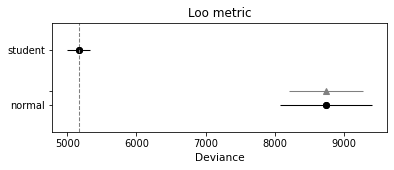

In [151]:
comp_loo = az.compare(comp_dict, ic='loo', scale='deviance')
az.plot_compare(comp_loo)
plt.title("Loo metric")
plt.show()

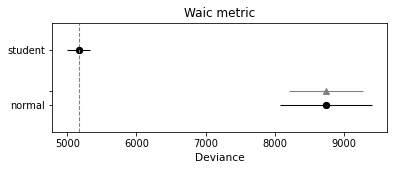

In [152]:
comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

Student model definitely better fits to data than model with normal distribution. 

In [153]:
%%writefile home/lab6_code_5.stan

data {
    int N;
    int K;
    array [N] real  y;
    matrix[N, K] X;
}

parameters {
    real<lower=0> sigma;
    vector [K] beta;
}

transformed parameters {
    vector [N] mu;
    mu = X * beta;
}

model {
    y ~ normal(mu, sigma);
}

generated quantities {
    vector [N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(y[j] | mu[j], sigma);
        y_hat[j] = normal_rng(mu[j], sigma);
    }
}

Overwriting home/lab6_code_5.stan


In [154]:
model_5=CmdStanModel(stan_file='home/lab6_code_5.stan')

INFO:cmdstanpy:compiling stan file /home/lab6_code_5.stan to exe file /home/lab6_code_5
INFO:cmdstanpy:compiled model executable: /home/lab6_code_5


In [155]:
df2.head()

,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[1191],y[1192],y[1193],y[1194],y[1195],y[1196],y[1197],y[1198],y[1199],y[1200]
0,0.0,0.0,2.70817,0.777181,-1.27227,0.127591,-1.38942,0.246162,1.19873,2.26533,...,-1.73839,5.82632,0.467584,5.68971,1.48844,-1.80466,-2.98097,2.59505,-3.23928,1.37315


1 predictor

In [156]:
dt_y = df2.loc[0, 'y[1]':]
dt_x = df2.loc[:, 'X[1,1]':f'X[{N},1]'].values.reshape((N, 1))
data_fit = {'N': N, 'K': 1, 'y': dt_y, 'X': dt_x}
#dt_y.shape
#dt_x.shape

In [157]:
fit_model_5_pred1 = model_5.sample(data=data_fit, iter_sampling=100, iter_warmup=1, chains=1, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


2 predictors

In [158]:
dt_y = df2.loc[0, 'y[1]':]
dt_x = df2.loc[:, 'X[1,1]':f'X[{N},2]'].values.reshape((N, 2))
data_fit = {'N': N, 'K': 2, 'y': dt_y, 'X': dt_x}
fit_model_5_pred2 = model_5.sample(data=data_fit, iter_sampling=100, iter_warmup=1, chains=1, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


3 predictors

In [159]:
dt_y = df2.loc[0, 'y[1]':]
dt_x = df2.loc[:, 'X[1,1]':f'X[{N},3]'].values.reshape((N, 3))
data_fit = {'N': N, 'K': 3, 'y': dt_y, 'X': dt_x}
fit_model_5_pred3 = model_5.sample(data=data_fit, iter_sampling=100, iter_warmup=1, chains=1, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


In [160]:
comp_dict = {
    'Model with 1 predictor': fit_model_5_pred1,
    'Model with 2 predictors': fit_model_5_pred2,
    'Model with 3 predictors': fit_model_5_pred3
    }

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated

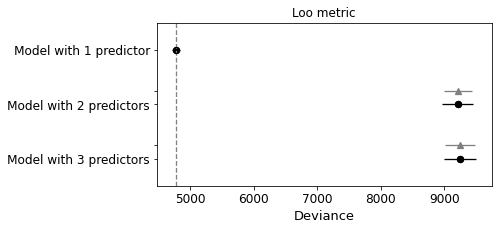

In [161]:
comp_loo = az.compare(compare_dict=comp_dict, ic='loo', scale='deviance')
az.plot_compare(comp_loo)
plt.title("Loo metric")
plt.show()

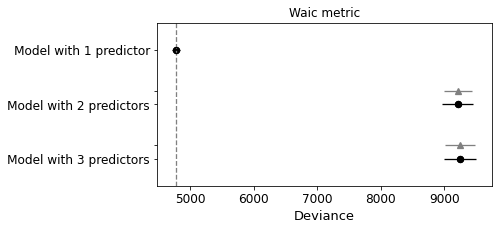

In [162]:
comp_waic = az.compare(compare_dict=comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

According to Loo and Waic metrics, model with 1 predictor fits the best to the generated data, models with 2 and 3 predictors are very similiar but significantly worse than first model.  